# 신경망 모델 훈련

In [2]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다. 
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

## 손실 곡선

In [3]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()       # 주의: 데이터셋마다 불러오는 함수가 다르다

train_scaled = train_input / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
def model_fn(a_layer=None):                                     # 은닉층 없는 것이 기본값
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))       # flatten 레이어
    model.add(keras.layers.Dense(100, activation='relu'))       # 입력 레이어
    if a_layer:
        model.add(a_layer)                                      # 은닉 레이어 추가할 경우 실행
    model.add(keras.layers.Dense(10, activation='softmax'))     # 마지막 출력 레이어
    return model

In [5]:
model = model_fn()          # 모델 선언

model.summary()             # summary 확인

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=5, verbose=0)        # verbose = 0 :  훈련 과정 나타내지 않음
# 'history' 객체에 훈련 결과 값을 담아줌

In [7]:
print(history.history.keys())       # 'history' 딕셔너리가 저장된다

dict_keys(['loss', 'accuracy'])


In [8]:
print(history.history['loss'])

[0.5311374068260193, 0.39091381430625916, 0.35448068380355835, 0.33128589391708374, 0.31468212604522705]


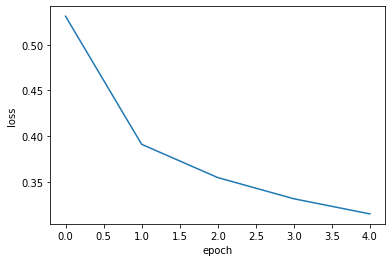

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [10]:
print(history.history['accuracy'])

[0.8112499713897705, 0.859458327293396, 0.8723958134651184, 0.8816249966621399, 0.8865208625793457]


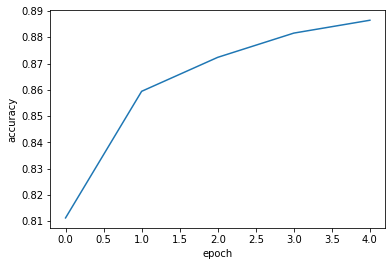

In [11]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [12]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0)       # epoch를 늘려보자

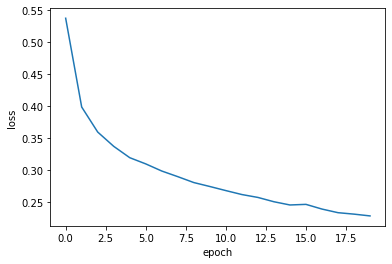

In [13]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 검증 손실

에포크에 따른 과대적합과 과소적합을 파악하려면 훈련 세트에 대한 점수뿐 아니라 검증 세트에 대한 점수도 필요   
4장에서는 정확도를 사용하여 과대/과소 적합을 설명했지만,   
여기서는 **손실**을 사용하여 과대/과소 적합을 다룬다.

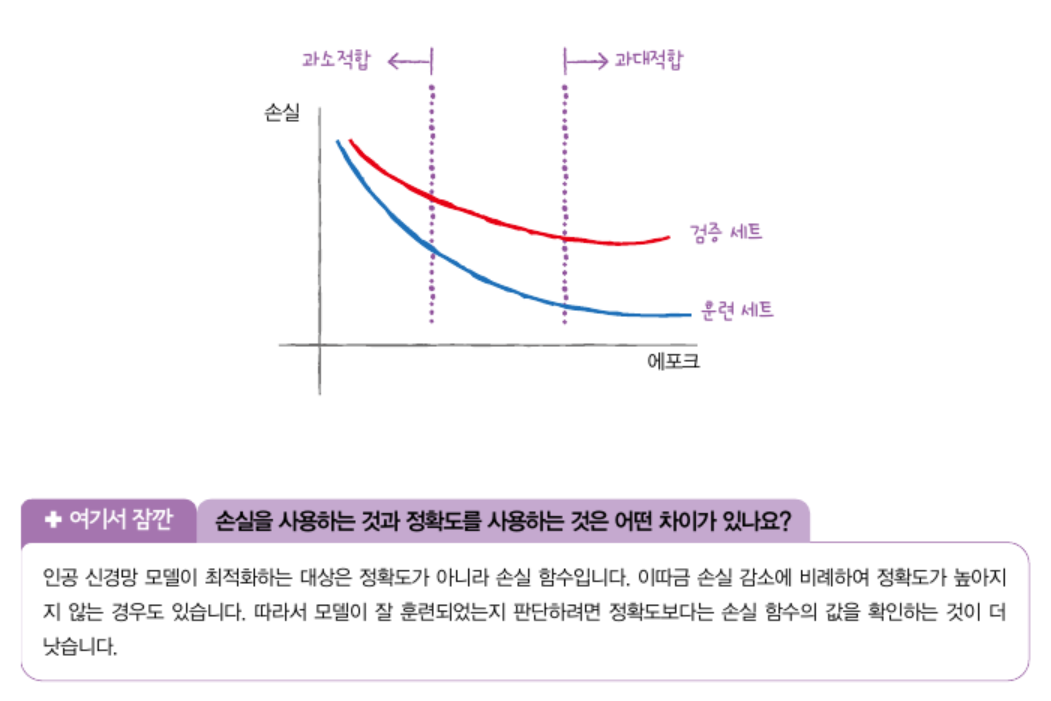

In [14]:
# 검증 세트를 추가해보자!

model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))               # 튜플 형태로 입력해야 한다.

In [15]:
print(history.history.keys())       # 검증 세트에 대한 손실과 정확도가 포함된 것을 확인할 수 있다.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


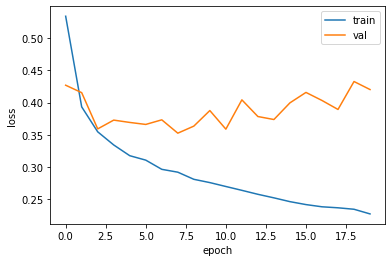

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

초기에 검증 손실이 감소하다가 다시 상승하기 시작한다.   
훈련 손실은 꾸준히 감소하기 때문에 에포크 값이 커질수록 전형적인 과대적합 모델이 만들어진다.   
검증 손실이 상승하는 시점을 가능한 뒤로 늦추면 검증 세트에 대한 손실이 줄어들 뿐 아니라 검증 세트에 대한 정확도도 증가할 것이다.   

신경망에 특화된 규제 방법을 사용할 수 있으나, 다음장에서.   
지금은 <u>optimizer의 하이퍼파라미터 값을 조정</u>하여 과대적합을 완화시키는 방법을 알아보자.   
RMSprop을 대체로 많이 쓰고, Adam은 적응적 학습률을 사용하기 때문에 에포크가 진행되면서 학습률의 크기를 조정할 수 있다.

In [17]:
# Adam 옵티마이저 사용
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))

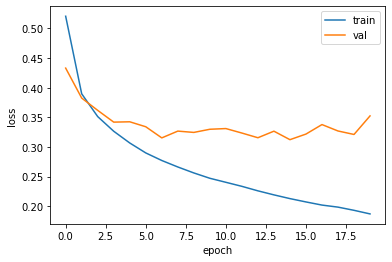

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 드롭아웃

훈련 과정에서 층에 있는 일부 뉴런을 랜덤하게 꺼서(뉴런의 출력을 0으로 만들어) 과대적합을 막는다.   
일부 뉴런이 랜덤하게 꺼지면 특정 뉴런에 과대하게 의존하는 것을 줄일 수 있고, 모든 입력에 대해 주의를 기울여야 한다.

In [19]:
model = model_fn(keras.layers.Dropout(0.3))     # 얼마나 많은 뉴런을 드롭할 지는 정해줘야 한다. 0.3이면, 30% 정도를 드롭아웃한다.

model.summary()     # 갯수는 그대로라는 것에 주의. 단지 뉴런의 출력을 0으로 만들 뿐이다.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))

훈련이 끝난 후 평가나 예측을 수행할 때는 드롭아웃을 적용하지 않아야 한다. : 텐서플로와 케라스는 평가와 예측 단계에서 드롭아웃을 적용하지 않는다.   
따라서 평가와 예측 단계에서도 모델을 그대로 사용하면 된다.

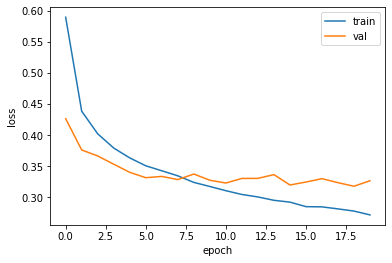

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

과대적합이 확실하게 줄어든 것을 확인할 수 있다.   
10번째 에포크 정도에서 검증 손실의 함수가 감소하는 것이 멈추지만, 크게 상승하지 않고 어느정도 유지된다.

다만, 20번 정도의 에포크 동안 훈련했기 때문에, 다소 과대적합된 경향이 있다. => 에포크 줄이면 된다.

## 모델 저장과 복원

모델을 저장해야 이후 다시 사용할 수 있다   
케라스 모델은 훈련된 모델의 파라미터를 저장하는 save_weights(),   
모델 구조와 모델 파라미터를 함께 저장하는 save() 메서드를 제공   

save_weights() 메서드는 기본적으로 텐서플로의 체크포인트 포맷으로 저장하지만,   
파일의 확장자를 '.h5'로 작성하면 HDF5 포맷으로 저장된다.   
save() 메서드는 기본적으로 텐서플로의 SavedModel 포맷으로 저장하지만,   
파일의 확장자를 '.h5'로 작성하면 HDF5 포맷으로 저장된다.

In [22]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=10, verbose=0, 
                    validation_data=(val_scaled, val_target))

In [23]:
# 모델 파라미터 저장!
model.save_weights('model-weights.h5')

In [24]:
# 모델 구조와 모델 파라미터를 함께 저장!
model.save('model-whole.h5')

In [25]:
# .h5 확장자로 저장한 리스트 확인하기!
!ls -al *.h5

-rw-r--r-- 1 root root 333448 Mar 13 06:32 model-weights.h5
-rw-r--r-- 1 root root 981360 Mar 13 06:32 model-whole.h5


In [26]:
model = model_fn(keras.layers.Dropout(0.3))     # 훈련하지 않은 새로운 모델 생성

model.load_weights('model-weights.h5')          # 이 모델에 model-weights.h5 파일에서 훈련된 모델 파라미터(weigths)를 읽어서 사용

주의) load_weights() 메서드를 사용하려면 save_weights() 메서드로 저장했던 모델과 정확히 같은 구조를 가져야 한다.   
이렇게 활용하기에도 모델 생성에 함수를 만들어 두는 것이 유용하다.

In [27]:
model.predict(val_scaled).shape

375/375 [==============================] - 1s 2ms/step


(12000, 10)

In [28]:
import numpy as np

val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))

375/375 [==============================] - 1s 3ms/step
0.8798333333333334


predict() 메서드 결과에서 가장 큰 값을 고르기 위해 numpy의 argmax() 함수 사용:   
axis = -1 : 배열의 마지막 차원을 따라 최댓값을 고른다.   

정확도를 확인하기 위해 argmax()로 도출한 인덱스(val_lavels_)와 타깃(val_target)을 비교[val_labels == val_target]   
맞으면 1, 틀리면 0, 모든 값의 평균을 내면 **정확도** 도출 가능


In [29]:
model = keras.models.load_model('model-whole.h5')   # 모델 전체가 저장된 파일을 읽을 때는 keras.models.load_model()

model.evaluate(val_scaled, val_target)

375/375 [==============================] - 2s 3ms/step - loss: 0.3359 - accuracy: 0.8798


[0.3358705937862396, 0.8798333406448364]

같은 모델을 저장하고 로드했기 때문에 정확도가 같은 것을 확인할 수 있다.   
(0.8798333333333334 // 0.8798333406448364)

## 콜백

In [30]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', 
                                                save_best_only=True)

model.fit(train_scaled, train_target, epochs=20, verbose=0, 
          validation_data=(val_scaled, val_target),
          callbacks=[checkpoint_cb])                    # 리스트로 전달하는 것 주의!

In [31]:
model = keras.models.load_model('best-model.h5')

model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3210 - accuracy: 0.8885


[0.3210257887840271, 0.8884999752044678]

In [32]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

In [33]:
# 훈련을 마치고 나면 몇 번째 에포크에서 훈련이 중지되었는지 early_stopping_cb 객체의 stopped_epoch 속성에서 확인할 수 있다.
print(early_stopping_cb.stopped_epoch)
# 에포크 횟수가 0부터 시작하기 때문에, 10은 11번째 에포크에서 훈련이 중지되었다는 것을 의미한다.
# patience를 2로 지정했으므로 최상의 모델은 9번째 에포크이다.
# 조기 종료 기법을 사용하면 안심하고 에포크 횟수를 크게 지정해도 괜찮다.

10


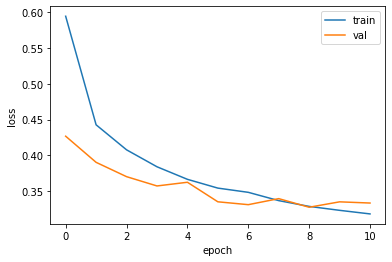

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [35]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.3276 - accuracy: 0.8817


[0.3275802731513977, 0.8816666603088379]